In [40]:
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.sql.functions import concat_ws, col # to concatinate cols
from pyspark.ml.classification import LogisticRegression # ml model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import DoubleType
from pyspark import SparkConf
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:

conf = SparkConf() \
    .setAppName("NewsClassification") \
    .setMaster("local[*]") 

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [19]:
df = spark.read.csv("data/news-dataset.csv", inferSchema=True, header=True)

In [20]:
# Renaming 'Class Index' col to 'label'
df = df.withColumnRenamed('Class Index', 'label')

# Add a new column 'Text' by concatinating 'Title' and 'Description'
df = df.withColumn("Text", concat_ws(" ", "Title", 'Description'))

# Remove old text columns
df = df.select('label', 'Text')

In [21]:
df.first()

Row(label='3', Text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [22]:
# convert sentences to list of words
tokenizer = RegexTokenizer(inputCol="Text", outputCol="words", pattern="\\W")

# adds a column 'words' to df after tokenization
df = tokenizer.transform(df)

df.select(['label','Text', 'words']).show(5)

+-----+--------------------+--------------------+
|label|                Text|               words|
+-----+--------------------+--------------------+
|    3|Wall St. Bears Cl...|[wall, st, bears,...|
|    3|Carlyle Looks Tow...|[carlyle, looks, ...|
|    3|Oil and Economy C...|[oil, and, econom...|
|    3|Iraq Halts Oil Ex...|[iraq, halts, oil...|
|    3|Oil prices soar t...|[oil, prices, soa...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [23]:
# to remove stop words like is, the, in, etc.
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# adds a column 'filtered' to df without stopwords
df = stopwords_remover.transform(df)

df.select(['label','Text', 'words', 'filtered']).first()

Row(label='3', Text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'])

In [24]:
# Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="filtered",
                       outputCol="raw_features", 
                       numFeatures=10000)

# adds raw tf features to df
featurized_data = hashing_tf.transform(df)

In [26]:
featurized_data.first()

Row(label='3', Text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'], raw_features=SparseVector(10000, {551: 1.0, 662: 1.0, 1262: 1.0, 1449: 1.0, 1889: 1.0, 1948: 1.0, 2503: 1.0, 2826: 1.0, 3038: 1.0, 3684: 1.0, 4443: 1.0, 6404: 2.0, 8318: 1.0, 8430: 1.0, 8450: 2.0, 9430: 1.0}))

In [27]:
# Inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="features")

idf_vectorizer = idf.fit(featurized_data)

# converting text to vectors
rescaled_data = idf_vectorizer.transform(featurized_data)

# top 20 rows
rescaled_data.select("label",'Text', 'words', 'filtered', "features").first()

Row(label='3', Text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'], features=SparseVector(10000, {551: 5.0673, 662: 6.0128, 1262: 4.8019, 1449: 5.9636, 1889: 6.9275, 1948: 4.9649, 2503: 7.6128, 2826: 5.9398, 3038: 4.6635, 3684: 4.3958, 4443: 5.7126, 6404: 9.1681, 8318: 8.034, 8430: 3.394, 8450: 4.6006, 9430: 6.4834}))

In [28]:
rescaled_data = rescaled_data.coalesce(1)
(train, test) = rescaled_data.randomSplit([0.80, 0.20])

In [30]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 103462


Test Dataset Count: 26071


In [32]:
train = train.withColumn("label", train["label"].cast(DoubleType()))
test = test.withColumn("label", test["label"].cast(DoubleType()))

In [33]:
train.filter(train['label'].isNull()).count()

3879

In [34]:
#remove nulls from train and test
train = train.na.drop()
test = test.na.drop()

In [35]:
train.filter(train['label'].isNull()).count()

0

In [21]:
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

lrModel = lr.fit(train)

24/11/19 00:17:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [36]:
# get predictions for test set
predictions = lrModel.transform(test)

In [41]:
#save the model
lrModel.write().overwrite().save("file:///C:/temp/models/lrModel")

In [42]:
lrModel = LogisticRegressionModel.load("lrModel")


In [38]:
# show top 10 predictions
predictions.select("Text", 'probability','prediction', 'label').show(10)

+--------------------+--------------------+----------+-----+
|                Text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
| #39;70,000 Darfu...|[6.19236050711398...|       1.0|  1.0|
| #39;9-11 helper ...|[6.42945055261540...|       1.0|  1.0|
| #39;Batman #39; ...|[9.74829759368188...|       1.0|  1.0|
| #39;Black Widows...|[4.01580214374555...|       1.0|  1.0|
| #39;Cheated #39;...|[1.08413835609316...|       2.0|  1.0|
| #39;Deserter #39...|[5.98935542775053...|       1.0|  1.0|
| #39;Half measure...|[1.09750637955379...|       1.0|  1.0|
| #39;Mbeki should...|[2.14914947302769...|       1.0|  1.0|
| #39;Mercenaries ...|[3.02693525938384...|       1.0|  1.0|
| #39;Militant #39...|[2.28787498677949...|       1.0|  1.0|
+--------------------+--------------------+----------+-----+
only showing top 10 rows



In [39]:
#accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
#accuracy in percentage
accuracy = evaluator.evaluate(predictions)*100
print("Accuracy: " + str(accuracy.__round__(2)) + "%")

Accuracy: 90.6%


/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


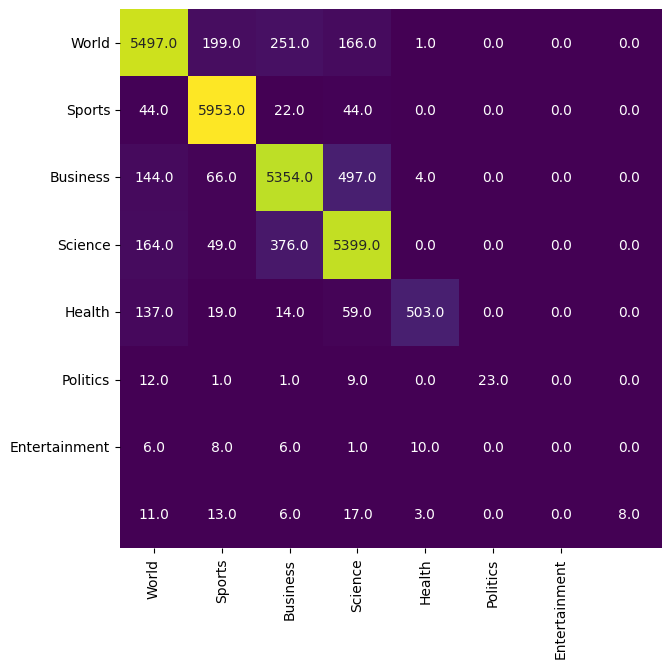

In [43]:
labels = ["World", "Sports", "Business","Science", "Health","Politics","Entertainment"]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']) \
                              .withColumn('label', col('label') \
                              ) \
                              .orderBy('prediction')

preds_and_labels_rdd = preds_and_labels.rdd.map(lambda row: (row['prediction'], row['label']))

# generate metrics
metrics = MulticlassMetrics(preds_and_labels_rdd)

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.show()

In [44]:
#a function that process a given news
def process_text(news):
    df = spark.createDataFrame([(news,)], schema=["news"]) 
    tokenizer = RegexTokenizer(inputCol="news", outputCol="words", pattern="\\W")
    df = tokenizer.transform(df)
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    df = stopwords_remover.transform(df)
    hashing_tf = HashingTF(inputCol="filtered",
                           outputCol="raw_features", 
                           numFeatures=10000)
    featurized_data = hashing_tf.transform(df)
    idf = IDF(inputCol="raw_features", outputCol="features")
    idf_vectorizer = idf.fit(featurized_data)
    rescaled_data = idf_vectorizer.transform(featurized_data)
    return rescaled_data

def predict(news):
    df = process_text(news)
    prediction = lrModel.transform(df)
    return prediction

prediction = predict("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [45]:
prediction.select('prediction').collect()[0]

Row(prediction=4.0)